# D-MPNN

### Load models

In [2]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch_geometric.data import Data, Batch   # only for type hints

def _maybe_dropout(rate: float) -> nn.Module:
    return nn.Dropout(rate) if rate > 0.0 else nn.Identity()

def _scatter_sum(src: Tensor, index: Tensor, dim_size: int) -> Tensor:
    """
    Fully-featured replacement for torch_scatter.scatter_add.
    Allocates a zero tensor of shape (dim_size, src.size(1)) and
    accumulates `src` rows whose destinations are in `index`.
    """
    out = torch.zeros(
        dim_size,
        src.size(1),
        dtype = src.dtype,
        device = src.device,
    )
    out.scatter_add_(
        dim = 0,
        index = index.unsqueeze(-1).expand_as(src),
        src = src,
    )
    return out

class BasicDMPNN(nn.Module):
    def __init__(
        self,
        atom_emb: int,
        bond_emb: int,
        msg_dim: int,
        msg_passes: int,
        out_hidden: int,
        emb_drop: float,
        msg_drop: float,
        head_drop: float,
    ):
        super().__init__()
        self.atom_embeddings = nn.Sequential(
            nn.Embedding(119, atom_emb),
            _maybe_dropout(emb_drop),
        )
        self.bond_embeddings = nn.Sequential(
            nn.Embedding(4, bond_emb),
            _maybe_dropout(emb_drop),
        )
        self.msg_init = nn.Linear(atom_emb + bond_emb, msg_dim)
        self.msg_update = nn.Linear(atom_emb + bond_emb + msg_dim, msg_dim)

        self.msg_passes = msg_passes
        self.msg_dropout = _maybe_dropout(msg_drop)

        self.readout = nn.Sequential(
            _maybe_dropout(head_drop),
            nn.Linear(msg_dim, out_hidden),
            nn.ReLU(),
            nn.Linear(out_hidden, 1),
        )

    def forward(self, data: Data | Batch) -> Tensor:
        atom = self.atom_embeddings(data.x)          # (num_atoms, atom_emb)
        bond = self.bond_embeddings(data.edge_attr)  # (num_edges, bond_emb)
        src, dst = data.edge_index                   # (2, num_edges)

        # 1. initial edge → message
        msg = F.relu(self.msg_init(torch.cat([atom[src], bond], dim=1)))

        # 2. message-passing iterations
        for _ in range(self.msg_passes):
            agg = _scatter_sum(msg, dst, dim_size=atom.size(0))
            upd_in = torch.cat([atom[src], bond, agg[src]], dim=1)
            msg = F.relu(self.msg_update(upd_in))
            msg = self.msg_dropout(msg)

        # 3. node & molecule readout
        node_state = _scatter_sum(msg, dst, dim_size=atom.size(0))
        num_molecules = int(data.batch.max().item()) + 1
        mol_state = _scatter_sum(node_state, data.batch, dim_size=num_molecules)

        return self.readout(mol_state).squeeze(-1)

/home/jday/anaconda3/envs/autogluon/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import joblib
import glob

MODEL_DIRECTORY_PATHS = [
    '../models/d_mpnn_Tg_502011',
    '../models/d_mpnn_FFV_45',
    '../models/d_mpnn_Tc_255',
    '../models/d_mpnn_Density_237',
    '../models/d_mpnn_Rg_14906',
]

# MODEL_DIRECTORY_PATHS = glob.glob('/kaggle/input/d-mpnn-models/d_mpnn_*_ds0')

TARGETS_TO_CONFIGS = {
    "Tg": { # Rerun MAE = 50.201104736328126
        "atom_emb": 40,
        "bond_emb": 16,
        "msg_dim": 242,
        "out_hidden": 62,
        "msg_passes": 5,
        "emb_drop": 0,
        "msg_drop": 0,
        "head_drop": 0.2691323902671593,
    },
    "FFV": { # Rerun MAE = 0.004520646389573812
        'atom_emb': 131, 
        "bond_emb": 16,
        'msg_dim': 515, 
        'out_hidden': 608, 
        'msg_passes': 7, 
        'emb_drop': 0.055918540183476806, 
        'msg_drop': 0, 
        'head_drop': 0.05, 
    },
    "Tc": { # Rerun MAE = 0.025551460683345795
        "atom_emb": 545,
        "bond_emb": 16,
        "msg_dim": 723,
        "out_hidden": 222,
        "msg_passes": 5,
        "emb_drop": 0,
        "msg_drop": 0.20329077329185974,
        "head_drop": 0.10640722466508153,
    },
    "Density": { # Rerun MAE = 0.023745716735720634
        "atom_emb": 31,
        "bond_emb": 16,
        "msg_dim": 305,
        "out_hidden": 786,
        "msg_passes": 5,
        "emb_drop": 0,
        "msg_drop": 0,
        "head_drop": 0,
    },
    "Rg": { # Rerun MAE = 1.490615677833557
        "atom_emb": 51,
        "bond_emb": 16,
        "msg_dim": 926,
        "out_hidden": 369,
        "msg_passes": 4,
        "emb_drop": 0,
        "msg_drop": 0,
        "head_drop": 0.10354626111613492,
    }
}

targets_to_models = {}
targets_to_scalers = {}
for model_directory_path in MODEL_DIRECTORY_PATHS:
    target_name = model_directory_path.split('/')[-1].split('_')[2]
    targets_to_models[target_name] = []
    targets_to_scalers[target_name] = []
    
    model_paths = sorted(glob.glob(f'{model_directory_path}/*.pth'))
    for model_path in model_paths:
        model = BasicDMPNN(**TARGETS_TO_CONFIGS[target_name]).cuda()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        targets_to_models[target_name].append(model)

    scaler_paths = sorted(glob.glob(f'{model_directory_path}/*.pkl'))
    for scaler_path in scaler_paths:
        scaler = joblib.load(scaler_path)
        targets_to_scalers[target_name].append(scaler)

    print(f'Loaded {len(targets_to_models[target_name])} models and {len(targets_to_scalers[target_name])} scalers for {target_name}')

/home/jday/anaconda3/envs/autogluon/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded 5 models and 5 scalers for Tg
Loaded 5 models and 5 scalers for FFV
Loaded 5 models and 5 scalers for Tc
Loaded 5 models and 5 scalers for Density
Loaded 5 models and 5 scalers for Rg


### Load data

In [4]:
import pandas as pd
from sklearn.model_selection import KFold

train_df = pd.read_csv('../data/from_host/train.csv')
display(train_df.head())

extra_df = pd.read_csv('../data/from_host_v2/train_host_plus_leaks_extra.csv')
display(extra_df.head())

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


,SMILES,Tg,FFV,Tc,Density,Rg
0,*Oc1cccc(NC(=O)c2ccc(P(=O)(c3ccccc3)c3ccc(C(=O...,NaN,0.368620,NaN,NaN,NaN
1,*Oc1cc(OC(=O)c2ccc(OCC(C)CC)cc2)c(OC(=O)CCCC(*...,NaN,0.357302,NaN,NaN,NaN
2,CCCCc1ccccc1,-144.15,NaN,NaN,NaN,NaN
3,*C(=O)Nc1ccc(Oc2cccc(NC(=O)c3ccc4c(c3)C(=O)N(c...,NaN,0.362688,NaN,NaN,NaN
4,*OS(=O)(=O)c1ccc(*)cc1,140.64,NaN,NaN,NaN,NaN


### Get predictions & labels for host data

In [5]:
import numpy as np

@torch.no_grad()
def get_predictions_and_labels(model, dataloader, scaler):
    predictions, labels = [], []
    for batch in dataloader:
        batch = batch.cuda()
        batch_predictions = model(batch)
        predictions.extend(batch_predictions.cpu().numpy())
        labels.extend(batch.y.cpu().numpy())

    predictions = np.array(predictions).reshape(-1,1)
    predictions = scaler.inverse_transform(predictions)

    labels = np.array(labels)

    return predictions, labels

In [6]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm

def bond_type_to_int(bond: Chem.Bond) -> int:
    mapping = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3,
    }
    return mapping.get(bond.GetBondType(), 0)


def smiles_to_labeled_graph(smiles: str, label: float) -> Data:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Bad SMILES: {smiles}")
    atom_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edge_indices, edge_attributes = [], []
    for bond in mol.GetBonds():
        start_index, end_index = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_type = bond_type_to_int(bond)
        edge_indices += [(start_index, end_index), (end_index, start_index)]
        edge_attributes += [bond_type, bond_type]
    return Data(
        x=torch.tensor(atom_nums, dtype=torch.long),
        edge_index=torch.tensor(edge_indices, dtype=torch.long).t(),
        edge_attr=torch.tensor(edge_attributes, dtype=torch.long),
        y=torch.tensor([label], dtype=torch.float32),
    )

In [7]:
from torch_geometric.loader import DataLoader

TARGET_NAMES = ["Tg", "FFV", "Tc", "Density", "Rg"]

targets_to_host_predictions = {target:[] for target in TARGET_NAMES}
targets_to_host_labels = {target:[] for target in TARGET_NAMES}
for target_name in TARGET_NAMES:
    FOLD_COUNT = 5
    kf = KFold(n_splits=FOLD_COUNT, shuffle=True, random_state=42)

    target_train_df = train_df.dropna(subset=target_name)
    for fold_index, (train_index, test_index) in enumerate(kf.split(target_train_df)):
        # LOAD MODEL & SCALER.
        model = targets_to_models[target_name][fold_index]
        scaler = targets_to_scalers[target_name][fold_index]
        
        # PREPARE DATALOADER.
        test_df = target_train_df.iloc[test_index]
        test_graphs = [
            smiles_to_labeled_graph(smiles, label) 
            for smiles, label
            in zip(test_df.SMILES, test_df[target_name].values)
        ]
        test_dataloader = DataLoader(test_graphs, shuffle=False, batch_size=64)

        # GENERATE PREDICTIONS.
        model_predictions, labels = get_predictions_and_labels(model, test_dataloader, scaler)

        # RECORD RESULTS.
        train_df.iloc[test_index]['fold'] = fold_index
        targets_to_host_predictions[target_name].extend(model_predictions.flatten())
        targets_to_host_labels[target_name].extend(labels.flatten())

/tmp/ipykernel_307132/3628806545.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.iloc[test_index]['fold'] = fold_index
/tmp/ipykernel_307132/3628806545.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.iloc[test_index]['fold'] = fold_index
/tmp/ipykernel_307132/3628806545.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

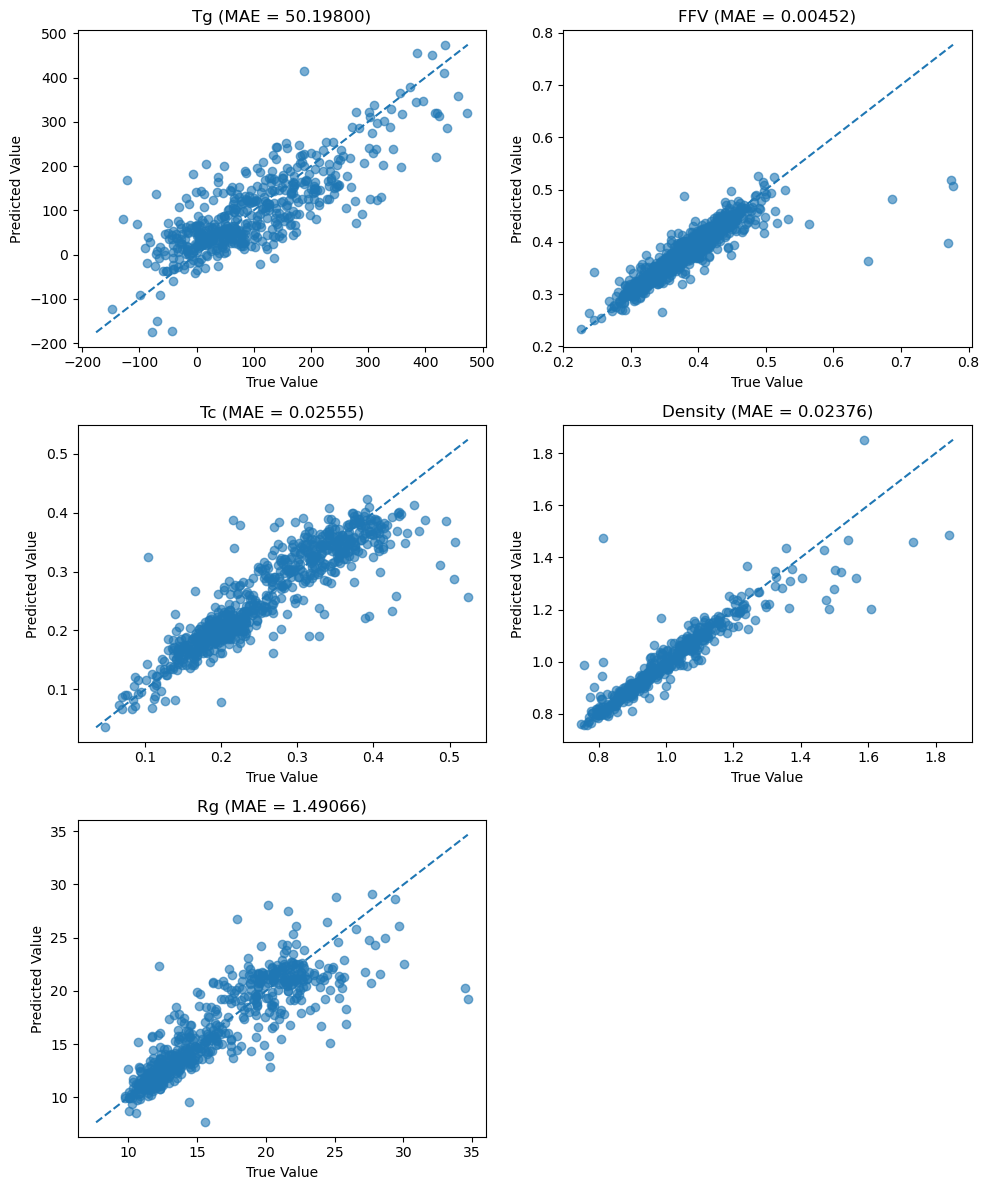

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# from cir_model import CenteredIsotonicRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

figure, axes_array = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 12))
axes_array = axes_array.flatten()

for subplot_index, target_name in enumerate(TARGET_NAMES):
    axis = axes_array[subplot_index]

    true_values = np.asarray(targets_to_host_labels[target_name])
    predicted_values = np.asarray(targets_to_host_predictions[target_name])

    # predicted_values += (predicted_values > np.mean(predicted_values)) * (0.2 * np.std(predicted_values))
    # predicted_values += (0.2 * np.std(predicted_values))

    kf = KFold(n_splits=5)
    rescaled_predictions = predicted_values.copy()
    for train_indices, test_indices in kf.split(predicted_values):
        train_preds, train_labels = predicted_values[train_indices], true_values[train_indices]
        test_preds, _ = predicted_values[test_indices], true_values[test_indices]
        # model = LinearRegression()
        # model.fit(train_preds.reshape(-1, 1), train_labels.reshape(-1, 1))
        # predicted_values[test_indices] = model.predict(test_preds.reshape(-1, 1)).flatten()
        model = IsotonicRegression(out_of_bounds='clip')
        model.fit(train_preds, train_labels)
        predicted_values[test_indices] = model.predict(test_preds)

        # print(test_indices)
    predicted_values = rescaled_predictions

    axis.scatter(true_values, predicted_values, alpha = 0.6)

    # Identity line for visual reference
    diagonal_minimum = float(min(true_values.min(), predicted_values.min()))
    diagonal_maximum = float(max(true_values.max(), predicted_values.max()))
    axis.plot([diagonal_minimum, diagonal_maximum],
              [diagonal_minimum, diagonal_maximum],
              linestyle = "--")

    mean_absolute_error = float(np.mean(np.abs(predicted_values - true_values)))
    axis.set_title(f"{target_name} (MAE = {mean_absolute_error:.5f})")
    axis.set_xlabel("True Value")
    axis.set_ylabel("Predicted Value")

# Hide the unused sixth subplot
if len(TARGET_NAMES) < len(axes_array):
    axes_array[-1].set_visible(False)

figure.tight_layout()
plt.show()


### Get predictions & labels for "extra" data

In [ ]:
targets_to_extra_predictions = {target:[] for target in TARGET_NAMES}
targets_to_extra_labels = {target:[] for target in TARGET_NAMES}
for target_name in TARGET_NAMES:
    target_extra_df = extra_df.dropna(subset=target_name)
    if len(target_extra_df) == 0:
        continue

    models = targets_to_models[target_name]
    scalers = targets_to_scalers[target_name]
    for model, scaler in zip(models, scalers):
        # PREPARE DATALOADER.
        test_graphs = [
            smiles_to_labeled_graph(smiles, label) 
            for smiles, label
            in zip(target_extra_df.SMILES, target_extra_df[target_name].values)
        ]
        test_dataloader = DataLoader(test_graphs, shuffle=False, batch_size=64)

        # GENERATE PREDICTIONS.
        model_predictions, labels = get_predictions_and_labels(model, test_dataloader, scaler)

        # RECORD RESULTS.
        targets_to_extra_predictions[target_name].extend(model_predictions.flatten())
        targets_to_extra_labels[target_name].extend(labels.flatten())

/home/jday/anaconda3/envs/torch2.7/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jday/anaconda3/envs/torch2.7/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


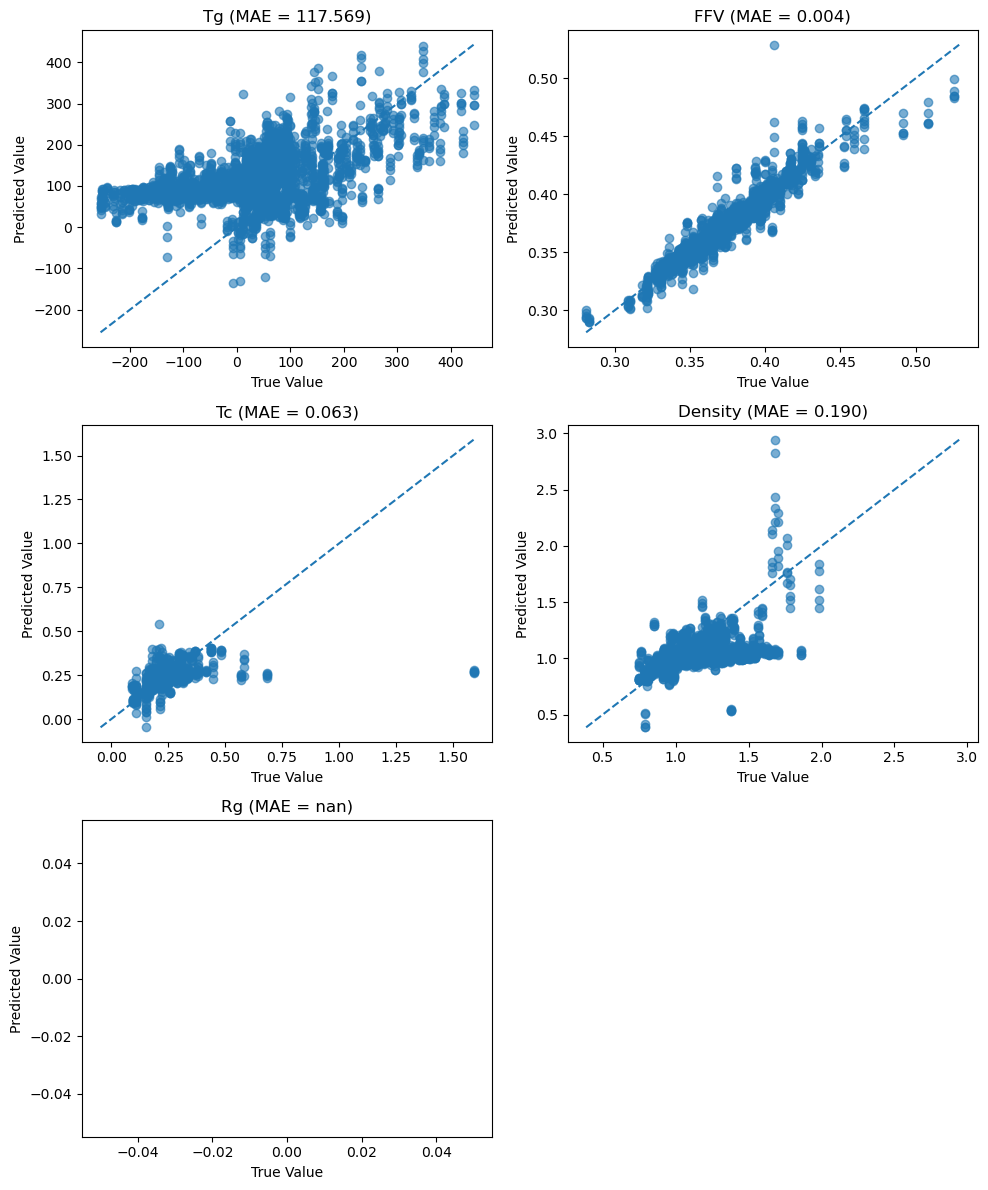

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

figure, axes_array = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 12))
axes_array = axes_array.flatten()

for subplot_index, target_name in enumerate(TARGET_NAMES):
    axis = axes_array[subplot_index]

    true_values = np.asarray(targets_to_extra_labels[target_name])
    predicted_values = np.asarray(targets_to_extra_predictions[target_name])

    axis.scatter(true_values, predicted_values, alpha = 0.6)

    # Identity line for visual reference
    if len(predicted_values) > 0:
        diagonal_minimum = float(min(true_values.min(), predicted_values.min()))
        diagonal_maximum = float(max(true_values.max(), predicted_values.max()))
        axis.plot([diagonal_minimum, diagonal_maximum],
                [diagonal_minimum, diagonal_maximum],
                linestyle = "--")

    mean_absolute_error = float(np.mean(np.abs(predicted_values - true_values)))
    axis.set_title(f"{target_name} (MAE = {mean_absolute_error:.3f})")
    axis.set_xlabel("True Value")
    axis.set_ylabel("Predicted Value")

# Hide the unused sixth subplot
if len(TARGET_NAMES) < len(axes_array):
    axes_array[-1].set_visible(False)

figure.tight_layout()
plt.show()


### Plot error histograms

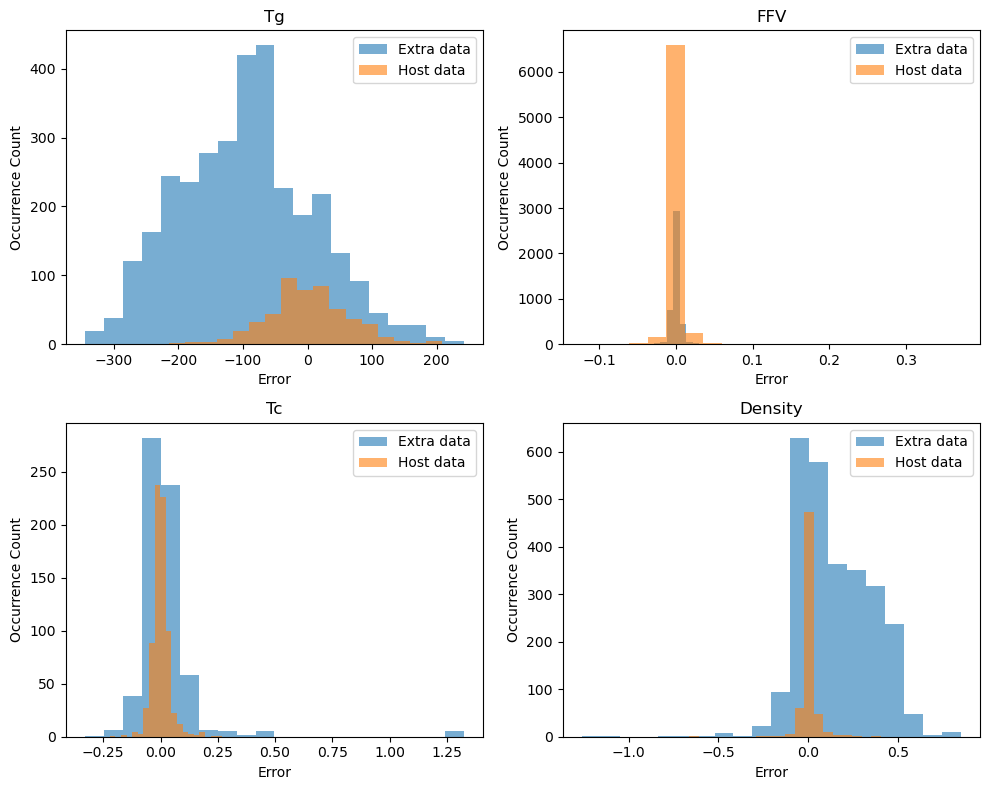

In [ ]:
figure, axes_array = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
axes_array = axes_array.flatten()

for subplot_index, target_name in enumerate(TARGET_NAMES[:4]):
    axis = axes_array[subplot_index]

    true_extra_values = np.asarray(targets_to_extra_labels[target_name])
    predicted_extra_values = np.asarray(targets_to_extra_predictions[target_name])
    true_host_values = np.asarray(targets_to_host_labels[target_name])
    predicted_host_values = np.asarray(targets_to_host_predictions[target_name])

    if len(true_extra_values) == 0:
        continue

    extra_errors = true_extra_values - predicted_extra_values
    host_errors = true_host_values - predicted_host_values

    axis.hist(extra_errors, bins=20, alpha=0.6, label='Extra data')
    axis.hist(host_errors, bins=20, alpha=0.6, label='Host data')

    axis.set_title(target_name)
    axis.set_xlabel("Error")
    axis.set_ylabel("Occurrence Count")
    axis.legend()

figure.tight_layout()

# Tabular models

In [9]:
import pickle
import json
import glob
from autogluon.tabular import TabularPredictor

MODEL_DIRECTORIES = [
    # 'models/LGBMRegressor_20250714_195253', # Seed 42
    # 'models/XGBRegressor_20250714_194646',
    # 'models/CatBoostRegressor_20250714_212440',
    # 'models/TabularPredictor_20250714_195408',
    # '../models/LGBMRegressor_20250714_210504', # Seed 69
    # '../models/XGBRegressor_20250714_210556',
    # '../models/CatBoostRegressor_20250714_211515',
    # '../models/TabularPredictor_20250714_223302',
    # '../models/LGBMRegressor_20250724_234051', # Seed 69, external data
    # '../models/XGBRegressor_20250724_234101',
    # '../models/CatBoostRegressor_20250724_234301',
    # '../models/TabularPredictor_20250725_003230',
    '../models/LGBMRegressor_20250729_074514', # Seed 69, external data, tuned extra data
    '../models/XGBRegressor_20250729_080504',
    # '../models/CatBoostRegressor_20250730_004438',
    # '../models/TabularPredictor_20250730_191705',
]
TARGET_NAMES = ["Tg", "FFV", "Tc", "Density", "Rg"]

targets_to_preprocessing_configs: dict[str,dict] = {}
targets_to_model_groups: dict[list[list]] = {}
for target_name in TARGET_NAMES:
    # LOAD TARGET MODELS & CONFIGS.
    targets_to_preprocessing_configs[target_name] = targets_to_preprocessing_configs.get(target_name, [])
    targets_to_model_groups[target_name] = targets_to_model_groups.get(target_name, [])
    for model_directory_path in MODEL_DIRECTORIES:
        # LOAD CONFIG.
        with open(f'{model_directory_path}/{target_name}_features_config.json', 'r') as config_file:
            config = json.load(config_file)
        targets_to_preprocessing_configs[target_name].append(config)

        # LOAD MODELS.
        model_group = []
        for model_path in sorted(glob.glob(f'{model_directory_path}/{target_name}*.pkl')):
            print(model_path)
            try:
                with open(model_path, 'rb') as model_file:
                    model = pickle.load(model_file)
                    model_group.append(model)
            except:
                model = TabularPredictor.load(model_path, require_py_version_match=False)
                model_group.append(model)
        targets_to_model_groups[target_name].append(model_group)

../models/LGBMRegressor_20250729_074514/Tg_fold0_mae429701.pkl
../models/LGBMRegressor_20250729_074514/Tg_fold1_mae429701.pkl
../models/LGBMRegressor_20250729_074514/Tg_fold2_mae429701.pkl
../models/LGBMRegressor_20250729_074514/Tg_fold3_mae429701.pkl
../models/LGBMRegressor_20250729_074514/Tg_fold4_mae429701.pkl
../models/XGBRegressor_20250729_080504/Tg_fold0_mae437801.pkl
../models/XGBRegressor_20250729_080504/Tg_fold1_mae437801.pkl
../models/XGBRegressor_20250729_080504/Tg_fold2_mae437801.pkl
../models/XGBRegressor_20250729_080504/Tg_fold3_mae437801.pkl
../models/XGBRegressor_20250729_080504/Tg_fold4_mae437801.pkl
../models/LGBMRegressor_20250729_074514/FFV_fold0_mae47.pkl
../models/LGBMRegressor_20250729_074514/FFV_fold1_mae47.pkl
../models/LGBMRegressor_20250729_074514/FFV_fold2_mae47.pkl
../models/LGBMRegressor_20250729_074514/FFV_fold3_mae47.pkl
../models/LGBMRegressor_20250729_074514/FFV_fold4_mae47.pkl
../models/XGBRegressor_20250729_080504/FFV_fold0_mae51.pkl
../models/XGBReg

In [10]:
import polars as pl
from functools import lru_cache
from rdkit import Chem
from rdkit.Chem import Descriptors, GraphDescriptors, MACCSkeys, rdFingerprintGenerator, AllChem, rdmolops
from rdkit.ML.Descriptors import MoleculeDescriptors
import networkx as nx
import pandas as pd

import sys
sys.path.append('..')
from fingerprinting_v5 import get_features_dataframe

# @lru_cache(maxsize=1_000_000)
# def get_feature_vector(
#         smiles: str,
#         morgan_fingerprint_dim: int,
#         atom_pair_fingerprint_dim: int,
#         torsion_dim: int,
#         use_maccs_keys: bool,
#         use_graph_features: bool):
#     # PARSE SMILES.
#     mol = Chem.MolFromSmiles(smiles)
    
#     # GET DESCRIPTORS.
#     descriptor_names = [descriptor[0] for descriptor in Descriptors._descList]
#     descriptor_generator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
#     descriptors = np.array(descriptor_generator.CalcDescriptors(mol))

#     # GET MORGAN FINGERPRINT.
#     morgan_fingerprint = np.array([])
#     if morgan_fingerprint_dim > 0:
#         morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=morgan_fingerprint_dim)
#         morgan_fingerprint = list(morgan_generator.GetFingerprint(mol))

#     # GET ATOM PAIR FINGERPRINT.
#     atom_pair_fingerprint = np.array([])
#     if atom_pair_fingerprint_dim > 0:
#         atom_pair_generator = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=atom_pair_fingerprint_dim)
#         atom_pair_fingerprint = list(atom_pair_generator.GetFingerprint(mol))

#     # GET MACCS.
#     maccs_keys = np.array([])
#     if use_maccs_keys:
#         maccs_keys = MACCSkeys.GenMACCSKeys(mol)
#         maccs_keys = list(maccs_keys)

#     # GET TORSION FINGERPRINT.
#     torsion_fingerprint = np.array([])
#     if torsion_dim > 0:
#         torsion_generator = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=torsion_dim)
#         torsion_fingerprint = list(torsion_generator.GetFingerprint(mol))

#     # GET GRAPH FEATURES.
#     graph_features = []
#     if use_graph_features:
#         adjacency_matrix = rdmolops.GetAdjacencyMatrix(mol)
#         graph = nx.from_numpy_array(adjacency_matrix)
#         graph_diameter = nx.diameter(graph) if nx.is_connected(graph) else 0
#         avg_shortest_path = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else 0
#         cycle_count = len(list(nx.cycle_basis(graph)))
#         graph_features = [graph_diameter, avg_shortest_path, cycle_count]

#     # CONCATENATE FEATURES.
#     features = np.concatenate([
#         descriptors, 
#         morgan_fingerprint, 
#         atom_pair_fingerprint, 
#         maccs_keys, 
#         torsion_fingerprint,
#         graph_features
#     ])
#     return features

# def get_features_dataframe(
#         smiles_df: pd.DataFrame, 
#         morgan_fingerprint_dim: int,
#         atom_pair_fingerprint_dim: int,
#         torsion_dim: int,
#         use_maccs_keys: bool,
#         use_graph_features: bool) -> tuple[pl.DataFrame, pl.DataFrame]:
#     # GET FEATURE NAMES.
#     descriptor_names = [descriptor[0] for descriptor in Descriptors._descList]
#     morgan_col_names = [f'mfp_{i}' for i in range(morgan_fingerprint_dim)]
#     atom_pair_col_names = [f'ap_{i}' for i in range(atom_pair_fingerprint_dim)]
#     maccs_col_names = [f'maccs_{i}' for i in range(167)] if use_maccs_keys else []
#     torsion_col_names = [f'tt_{i}' for i in range(torsion_dim)]
#     graph_col_names = ['graph_diameter', 'avg_shortest_path', 'num_cycles'] if use_graph_features else []
#     feature_col_names = descriptor_names + morgan_col_names + atom_pair_col_names + maccs_col_names + torsion_col_names + graph_col_names

#     # GET FEATURES.
#     features_df = pd.DataFrame(
#         np.vstack([
#             get_feature_vector(
#                 smiles,
#                 morgan_fingerprint_dim,
#                 atom_pair_fingerprint_dim,
#                 torsion_dim,
#                 use_maccs_keys,
#                 use_graph_features
#             ) 
#             for smiles 
#             in smiles_df['SMILES']]),
#         columns=feature_col_names
#     )

#     # CLEAN FEATURES.
#     f32_max = np.finfo(np.float32).max
#     features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     features_df[features_df > f32_max] = np.nan
#     features_df[features_df < -f32_max] = np.nan

#     return features_df

In [11]:
from sklearn.metrics import mean_absolute_error
import numpy as np

TARGET_NAMES = ["Tg", "FFV", "Tc", "Density", "Rg"]

targets_to_model_groups_predictions = {target:[] for target in TARGET_NAMES}
targets_to_host_labels = {target:[] for target in TARGET_NAMES}
for target_name in TARGET_NAMES:
    # LOAD MODEL GROUPS.
    preprocessing_configs = targets_to_preprocessing_configs[target_name]
    model_groups = targets_to_model_groups[target_name]

    # FILTER DATA.
    target_train_df = train_df.dropna(subset=target_name)
    
    # GENERATE PREDICTIONS WITH EACH GROUP.
    model_groups_predictions = []
    for group_index, (preprocessing_config, model_group) in enumerate(zip(preprocessing_configs, model_groups)):
        # FOLD INFERENCE.
        model_group_predictions = []
        test_labels = []

        FOLD_COUNT = 5
        # kf = KFold(n_splits=FOLD_COUNT, shuffle=True, random_state=42)
        kf = KFold(n_splits=FOLD_COUNT, shuffle=True, random_state=69)
        for fold_index, (train_index, test_index) in enumerate(kf.split(target_train_df)):
            test_df = target_train_df.iloc[test_index]
            test_labels.extend(test_df[target_name].iloc)

            features_df = get_features_dataframe(test_df, **preprocessing_config)

            model = model_group[fold_index]
            predictions = model.predict(features_df)
            model_group_predictions.extend(predictions)

        model_groups_predictions.append(model_group_predictions)
        print(f'{target_name}, Group {group_index} MAE:', mean_absolute_error(model_group_predictions, test_labels))

    targets_to_model_groups_predictions[target_name] = model_groups_predictions
    targets_to_host_labels[target_name] = test_labels

Tg, Group 0 MAE: 42.970170438250946
Tg, Group 1 MAE: 43.780104366332715
FFV, Group 0 MAE: 0.004724365621024366
FFV, Group 1 MAE: 0.005116175421548943
Tc, Group 0 MAE: 0.024302901977844845
Tc, Group 1 MAE: 0.02384130694084392
Density, Group 0 MAE: 0.02556957397552938
Density, Group 1 MAE: 0.02563611688118795
Rg, Group 0 MAE: 1.3014828189456562
Rg, Group 1 MAE: 1.3121210567775228


In [12]:
def get_target_weights(csv_path, target_names):
    df = pd.read_csv(csv_path)

    scale_normalization_factors = []
    sample_count_normalization_factors = []
    for target in target_names:
        target_values = df[target].values
        target_values = target_values[~np.isnan(target_values)]

        scale_normalization_factors.append(1 / (max(target_values) - min(target_values)))
        sample_count_normalization_factors.append((1/len(target_values))**0.5)

    scale_normalization_factors = np.array(scale_normalization_factors)
    sample_count_normalization_factors = np.array(sample_count_normalization_factors)

    class_weights = scale_normalization_factors * len(target_names) * sample_count_normalization_factors / sum(sample_count_normalization_factors)

    return class_weights

target_weights = get_target_weights('../data/from_host/train.csv', TARGET_NAMES)
target_weights

array([2.05237750e-03, 6.23924866e-01, 2.21997544e+00, 1.06409418e+00,
       4.65581184e-02])

In [13]:
from sklearn.linear_model import Ridge

mean_averaging_mae_scores = []
median_averaging_mae_scores = []
ridge_mae_scores = []

for target_name in TARGET_NAMES:
    model_groups_predictions = targets_to_model_groups_predictions[target_name]
    host_labels = targets_to_host_labels[target_name]

    mean_predictions = np.mean(model_groups_predictions, axis=0)
    mean_averaging_mae_scores.append(mean_absolute_error(mean_predictions, host_labels))

    median_predictions = np.median(model_groups_predictions, axis=0)
    median_averaging_mae_scores.append(mean_absolute_error(median_predictions, host_labels))

    kf = KFold(n_splits=5, shuffle=False)
    current_target_ridge_mae_scores = []
    model_groups_predictions, host_labels = np.array(model_groups_predictions).T, np.array(host_labels).T
    for train_indices, test_indices in kf.split(host_labels):
        train_features = model_groups_predictions[train_indices]
        train_labels = host_labels[train_indices]
        test_features = model_groups_predictions[test_indices]
        test_labels = host_labels[test_indices]

        model = Ridge(alpha=.1, fit_intercept=False, positive=True)
        model.fit(train_features, train_labels)

        ensemble_predictions = model.predict(test_features)
        current_target_ridge_mae_scores.append(mean_absolute_error(ensemble_predictions, test_labels))
    ridge_mae_scores.append(np.mean(current_target_ridge_mae_scores))

print('Mean averaging wMAE:', np.average(mean_averaging_mae_scores, weights=target_weights))
print('Median averaging wMAE:', np.average(median_averaging_mae_scores, weights=target_weights))
print('Ridge wMAE:', np.average(ridge_mae_scores, weights=target_weights))

Mean averaging wMAE: 0.05799166921582989
Median averaging wMAE: 0.05799166921582989
Ridge wMAE: 0.058514051616168725


In [14]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.optimize import minimize   # Nelder–Mead

mean_averaging_mae_scores = []
median_averaging_mae_scores = []
ridge_mae_scores = []
weighted_averaging_mae_scores = []

for target_name in TARGET_NAMES:
    # LOAD PREDICTIONS & LABELS
    model_groups_predictions = targets_to_model_groups_predictions[target_name]
    host_labels = targets_to_host_labels[target_name]

    # TRY SIMPLE AVERAGING STRATEGIES.
    mean_predictions = np.mean(model_groups_predictions, axis=0)
    mean_averaging_mae_scores.append(mean_absolute_error(mean_predictions, host_labels))

    median_predictions = np.median(model_groups_predictions, axis=0)
    median_averaging_mae_scores.append( mean_absolute_error(median_predictions, host_labels))

    # RESHAPE FOR RIDGE & NELDER-MEAD
    model_groups_predictions = np.array(model_groups_predictions).T
    host_labels = np.array(host_labels).T

    # RIDGE REGRESSION.
    kf = KFold(n_splits=5, shuffle=False)
    current_target_ridge_mae_scores = []
    for train_indices, test_indices in kf.split(host_labels):
        train_features = model_groups_predictions[train_indices]
        train_labels = host_labels[train_indices]
        test_features = model_groups_predictions[test_indices]
        test_labels = host_labels[test_indices]

        model = Ridge(alpha=0.1, fit_intercept=False, positive=True)
        model.fit(train_features, train_labels)

        ensemble_predictions = model.predict(test_features)
        current_target_ridge_mae_scores.append(
            mean_absolute_error(ensemble_predictions, test_labels)
        )
    ridge_mae_scores.append(np.mean(current_target_ridge_mae_scores))

    # WEIGHTED AVERAGING.
    current_target_weighted_mae_scores = []
    number_of_models = model_groups_predictions.shape[1]

    def _objective(
        raw_weights: np.ndarray,
        features: np.ndarray,
        labels: np.ndarray,
    ) -> float:
        """Return MAE for *normalised* positive weights derived from raw_weights."""
        positive_weights = np.abs(raw_weights)
        weight_sum = positive_weights.sum()
        if weight_sum == 0.0:  # avoid divide‑by‑zero
            positive_weights = np.ones_like(positive_weights)
            weight_sum = positive_weights.sum()
        normalised_weights = positive_weights / weight_sum
        weighted_predictions = features @ normalised_weights
        return mean_absolute_error(weighted_predictions, labels)

    selected_weights = []
    for train_indices, test_indices in kf.split(host_labels):
        train_features = model_groups_predictions[train_indices]
        train_labels = host_labels[train_indices]
        test_features = model_groups_predictions[test_indices]
        test_labels = host_labels[test_indices]

        initial_weights = np.ones(number_of_models)
        optimisation_result = minimize(
            fun=_objective,
            x0=initial_weights,
            args=(train_features, train_labels),
            method="Nelder-Mead",
            options={"maxiter": 1000, "fatol": 1e-6},
        )

        optimal_raw_weights = optimisation_result.x
        positive_weights = np.abs(optimal_raw_weights)
        normalised_weights = positive_weights / positive_weights.sum()
        normalised_weights += 0.05 # Regularization, avoid small weights
        normalised_weights = normalised_weights / normalised_weights.sum()
        weighted_predictions = test_features @ normalised_weights

        # print(normalised_weights)
        selected_weights.append(normalised_weights)

        current_target_weighted_mae_scores.append(mean_absolute_error(weighted_predictions, test_labels))
    
    print(f'"{target_name}":', np.mean(selected_weights, axis=0).tolist())

    weighted_averaging_mae_scores.append(np.mean(current_target_weighted_mae_scores))

# REPORT METRICS.
print("\nMean averaging wMAE:", np.average(mean_averaging_mae_scores, weights=target_weights))
print("Median averaging wMAE:", np.average(median_averaging_mae_scores, weights=target_weights))
print("Ridge wMAE:", np.average(ridge_mae_scores, weights=target_weights))
print("Nelder-Mead wMAE:", np.average(weighted_averaging_mae_scores, weights=target_weights))


"Tg": [0.6979834394854919, 0.3020165605145081]
"FFV": [0.7568425892475883, 0.24315741075241162]
"Tc": [0.4290150801510312, 0.5709849198489688]
"Density": [0.5282107599386348, 0.47178924006136524]
"Rg": [0.522173282367571, 0.477826717632429]

Mean averaging wMAE: 0.05799166921582989
Median averaging wMAE: 0.05799166921582989
Ridge wMAE: 0.058514051616168725
Nelder-Mead wMAE: 0.05809396405166802
